In [2]:
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers, initializers
import numpy as np
from matplotlib import pyplot as plt
import random

random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

In [3]:
(x_trainval, y_trainval), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #mnist 불러오는 코드
x_trainval, x_test = tf.cast(x_trainval, tf.float32), tf.cast(x_test, tf.float32) #int (0~255) -> normalization
y_trainval, y_test = tf.cast(y_trainval, tf.float32), tf.cast(y_test, tf.float32)

num_classes = 10
num_features = 784  # 28*28 -> 한 줄로 풀면 784

x_trainval, x_test = tf.reshape(x_trainval,[-1, num_features]), tf.reshape(x_test, [-1, num_features]) # (28*28) -> (1,784) 
x_trainval, x_test = x_trainval / 255., x_test / 255. # 0~255 -> 0~1

2023-06-19 16:00:18.090087: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
indices = np.random.permutation(x_trainval.shape[0])
x_trainval = tf.gather(x_trainval, indices)
y_trainval = tf.gather(y_trainval, indices)

x_train = x_trainval[:50000]  
y_train = y_trainval[:50000]
x_val = x_trainval[50000:] 
y_val = y_trainval[50000:]

batch_size = 200
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(50000).batch(batch_size).prefetch(1)

In [5]:
def cross_entropy_loss(x, y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    return tf.reduce_mean(loss)

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    
def Train_model(model, lr, epo, print_loss=True, plot_graph=True):
    step_l = []
    loss_l = []
    
    optimizer = tf.optimizers.SGD(lr, momentum=0.9)
    
    for epoch in range(1,epo+1):
        for step, (batch_x, batch_y) in enumerate(train_data, 1):
            with tf.GradientTape() as g:
                pred = model(batch_x, is_training=True)
                loss = cross_entropy_loss(pred, batch_y)

            trainable_variables = model.trainable_variables
            gradients = g.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))
            
            if plot_graph:
                if step % 50 == 0:
                    step_l.append((epoch-1)*300 + step)
                    loss_l.append(loss.numpy())
        if print_loss:
            acc = accuracy(model(x_test), y_test)
            print("epoch: ", epoch, ", loss: ", loss.numpy(), "acc: ", acc)
    
    if plot_graph:
        plt.plot(step_l, loss_l)
    return model

In [6]:
class NeuralNet(Model): # Regularization skill을 추가하지 않은 기본 뉴럴네트워크 구조
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = layers.Dense(128, kernel_initializer = initializers.GlorotNormal())
        self.bn1 = layers.BatchNormalization()
        self.ac1 = layers.Activation(tf.nn.relu)
        self.fc2 = layers.Dense(256, kernel_initializer = initializers.GlorotNormal())
        self.bn2 = layers.BatchNormalization()
        self.ac2 = layers.Activation(tf.nn.relu)
        self.out = layers.Dense(num_classes, kernel_initializer = initializers.GlorotNormal())

    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.bn2(x, training=is_training)
        x = self.ac2(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

In [8]:
#Early stopping

import sys
import copy

val_data = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_data = val_data.shuffle(10000).batch(batch_size).prefetch(1)

def early_stopping(model, lr):
    # plot 하기 위해 씀
    el = []
    vll = []
    
    # 얼마나 참을 건지 - 5번까지 로스 증가는 괜찮, 6번부터 로스 증가하면 학습중단
    p = 5 #patience
    
    i = 0 # epoch
    j = 0 # 현재 참은 횟수
    v = sys.float_info.max #
    
    models = copy.deepcopy(model) # 제일 좋은 모델
    
    i_s = i
    
    while j < p:
        Train_model(model, lr, 1, print_loss=False, plot_graph=False)
        
        acc = accuracy(model(x_val), y_val) * 100
        tmp_v = 100 -acc # 현재 모델의 에러 EX) 80 -> TMP_V 20 ---> 79  -> 21
        i += 1 # epoch
        
        print("epoch reached", i , 'current validation error', tmp_v, 'smallest error', v)
        
        el.append(i)
        vll.append(tmp_v)
        
        if tmp_v < v: # 모델이 잘 학습되고 있음
            j = 0 # 참은 횟수 초기화
            model_s = copy.deepcopy(model) # 제일 좋은 모델 저장
            i_s = i # 가장 좋은 epoch (best epoch)
            v = tmp_v # smallest error
        else:
            j += 1 # 참은 횟수 증가
    plt.plot(el, vll) # 
    print('best epoch', i_s)
    return model_s, i_s

2023-06-19 16:25:52.710296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [50000]
	 [[{{node Placeholder/_1}}]]


epoch reached 1 current validation error 5.449998378753662 smallest error 1.7976931348623157e+308
epoch reached 2 current validation error 3.7199974060058594 smallest error 5.449998378753662
epoch reached 3 current validation error 3.329998254776001 smallest error 3.7199974060058594
epoch reached 4 current validation error 2.8400003910064697 smallest error 3.329998254776001
epoch reached 5 current validation error 3.0300021171569824 smallest error 2.8400003910064697
epoch reached 6 current validation error 2.8199970722198486 smallest error 2.8400003910064697
epoch reached 7 current validation error 2.6099979877471924 smallest error 2.8199970722198486
epoch reached 8 current validation error 2.5399982929229736 smallest error 2.6099979877471924
epoch reached 9 current validation error 2.5300025939941406 smallest error 2.5399982929229736
epoch reached 10 current validation error 2.4299979209899902 smallest error 2.5300025939941406
epoch reached 11 current validation error 2.48000025749206

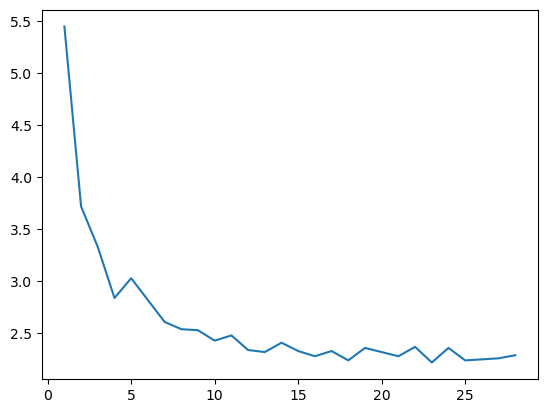

In [9]:
neural_net = NeuralNet()
neural_net, best_epoch = early_stopping(neural_net, 0.01)

In [24]:
#weight decay
class WD_NeuralNet(Model): # Regularization skill을 추가하지 않은 기본 뉴럴네트워크 구조
    def __init__(self):
        super(WD_NeuralNet, self).__init__()
        self.fc1 = layers.Dense(128, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer = regularizers.l2(0.01))
        self.bn1 = layers.BatchNormalization()
        self.ac1 = layers.Activation(tf.nn.relu)
        self.fc2 = layers.Dense(256, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer = regularizers.l2(0.01))
        self.bn2 = layers.BatchNormalization()
        self.ac2 = layers.Activation(tf.nn.relu)
        self.out = layers.Dense(num_classes, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer = regularizers.l2(0.01))

    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.bn2(x, training=is_training)
        x = self.ac2(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

epoch reached 1 current validation error 5.199998617172241 smallest error 1.7976931348623157e+308
epoch reached 2 current validation error 3.780001401901245 smallest error 5.199998617172241
epoch reached 3 current validation error 3.2400012016296387 smallest error 3.780001401901245
epoch reached 4 current validation error 2.999997138977051 smallest error 3.2400012016296387
epoch reached 5 current validation error 2.770000696182251 smallest error 2.999997138977051
epoch reached 6 current validation error 2.8400003910064697 smallest error 2.770000696182251
epoch reached 7 current validation error 2.619999647140503 smallest error 2.770000696182251
epoch reached 8 current validation error 2.469998598098755 smallest error 2.619999647140503
epoch reached 9 current validation error 2.369999885559082 smallest error 2.469998598098755
epoch reached 10 current validation error 2.4200022220611572 smallest error 2.369999885559082
epoch reached 11 current validation error 2.52000093460083 smallest e

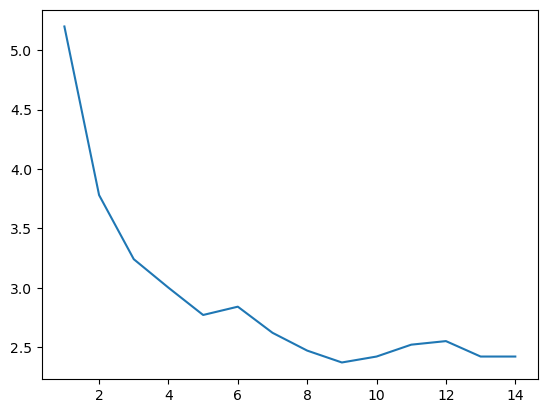

In [25]:
wd_nn = WD_NeuralNet()
wd_nn, wd_best_epoch = early_stopping(wd_nn, 0.01)

In [26]:
# drop out
class DO_NeuralNet(Model): # Regularization skill을 추가하지 않은 기본 뉴럴네트워크 구조
    def __init__(self):
        super(DO_NeuralNet, self).__init__()
        self.fc1 = layers.Dense(128, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer = regularizers.l2(0.01))
        self.bn1 = layers.BatchNormalization()
        self.ac1 = layers.Activation(tf.nn.relu)
        self.do1 = layers.Dropout(rate=0.5)
        self.fc2 = layers.Dense(256, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer = regularizers.l2(0.01))
        self.bn2 = layers.BatchNormalization()
        self.ac2 = layers.Activation(tf.nn.relu)
        self.do2 = layers.Dropout(rate=0.5)
        self.out = layers.Dense(num_classes, kernel_initializer = initializers.GlorotNormal(), kernel_regularizer = regularizers.l2(0.01))

    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = self.ac1(x)
        x = self.do1(x, training=is_training)
        x = self.fc2(x)
        x = self.bn2(x, training=is_training)
        x = self.ac2(x)
        x = self.do2(x, training=is_training)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

epoch reached 1 current validation error 8.459997177124023 smallest error 1.7976931348623157e+308
epoch reached 2 current validation error 6.870001554489136 smallest error 8.459997177124023
epoch reached 3 current validation error 5.970001220703125 smallest error 6.870001554489136
epoch reached 4 current validation error 5.330002307891846 smallest error 5.970001220703125
epoch reached 5 current validation error 5.059999227523804 smallest error 5.330002307891846
epoch reached 6 current validation error 4.699999094009399 smallest error 5.059999227523804
epoch reached 7 current validation error 4.439997673034668 smallest error 4.699999094009399
epoch reached 8 current validation error 4.2999982833862305 smallest error 4.439997673034668
epoch reached 9 current validation error 4.100000858306885 smallest error 4.2999982833862305
epoch reached 10 current validation error 3.880000114440918 smallest error 4.100000858306885
epoch reached 11 current validation error 3.789997100830078 smallest er

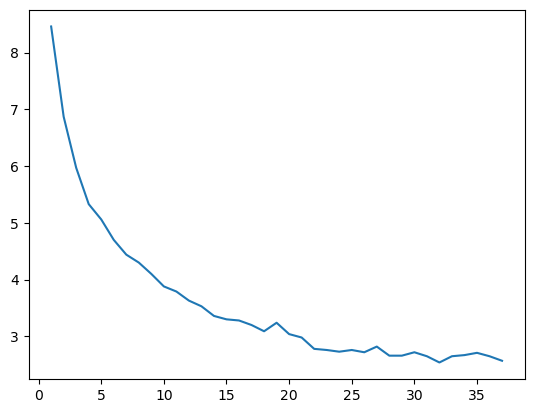

In [27]:
do_nn = DO_NeuralNet()
do_nn, do_best_epoch = early_stopping(do_nn, 0.01)